In [1]:
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np


In [2]:
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()                  

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure, including the following
  1. data : key containing an array with one row per instance and one column per feature
  2. DESCR : key describing dataset
  3. target: key containing an array with labels


In [3]:
X,y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

There are 70000 images with 784 features.This is because each image is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black)

In [4]:
print(len(X[0]) )
print(y[2])
print(X[0].shape)

784
4
(784,)


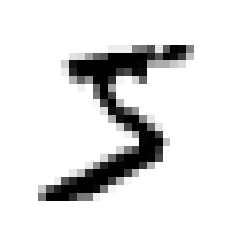

In [5]:
## peek at one digit from the dataset
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap='binary')
plt.axis('off')
plt.show()

In [6]:
print(some_digit_image.shape)
y[0]

(28, 28)


'5'

In [7]:
y = y.astype(np.uint8)
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

In [8]:
X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

The training set is already shuffled for us, which is good because this guarantees that all cross-validation folds will be similar.

### Training a Binary Classifier

Try to identify one digit—for example, the number 5. This “5-detector” will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and not-5

In [9]:
y_train5 =(y_train==5)
y_test5 = (y_test==5)


In [10]:
y_train5

array([ True, False, False, ...,  True, False, False])

 Picking SGD(stochastic gradient descent) classifier and train it.<br>
 SGD deals with training instances independently, one at a time 

In [11]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
##  use it to detect images of the number 5
sgd_clf.predict([some_digit])

array([ True])

The classifier guesses that this image represents a 5 (True). <br>
let’s evaluate this model’s performance.

#### Performance Measures

**Measuring Accuracy Using Cross-Validation**

In [13]:
## Implementing Cross Validation 
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train,y_train5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  X_test_folds = X_train[test_index]
  y_train_folds = y_train5[train_index]
  y_test_folds = y_train5[test_index]

  clone_clf.fit(X_train_folds,y_train_folds)
  y_pred= clone_clf.predict(X_test_folds)
  n_correct = sum(y_pred==y_test_folds)
  print(n_correct/len(y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


StratifiedKFold class performs stratified sampling to produce folds that contain a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions.

In [14]:
for train_index, test_index in skfolds.split(X_train,y_train5):
  print(train_index,)

[19964 19965 19966 ... 59997 59998 59999]
[    0     1     2 ... 59997 59998 59999]
[    0     1     2 ... 40088 40125 40127]


In [15]:
## using cross_val_score to evaluate SGDClassifier using K-folds with 3 folds 
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train5, cv=3,scoring='accuracy')


array([0.95035, 0.96035, 0.9604 ])

let’s look at a very dumb classifier that just classifies every single image in the “not-5” class

In [16]:
np.zeros((len(X_train),1),dtype=bool)

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [17]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
  def fit(self,X,y=None):
    pass
  def predict(self,X):
    return np.zeros((len(X),1),dtype=bool)

In [18]:
## testing this model Accuracy
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train5, cv=3,scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [19]:
sum(y_train5)*100/len(y_train5)

9.035

it has over 90% accuracy! This is simply because only ~~ 10% of the images are 5s ( as it can be seen in above cell ), so if you always guess that an image is not a 5, you will be right about 90% of the time.

This shows **why accuracy is generally not the preferred performance measure** for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).

**Confusion Matrix**

The idea is to count the number of times instances of class A are classified as class B.<br>
To compute the confusion matrix, we first need to have a set of predictions so that they can be compared to the actual targets

In [20]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train5,cv=3)

Just like the cross_val_score function,cross_val_predict
performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training se

In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. <br>
The first row of this matrix considers non-5 images (the negative class): 53,892 of them were correctly classified as non-5s (they are called true negatives),while the remaining 687 were wrongly classified as 5s (false positives) <br>
The second row considers the images of 5s (the positive class): 1,891 were wrongly classified as non-5s (false negatives), while the remaining 3,530 were correctly classified as 5s (true positives). 

In [22]:
## pretend we reach perfection
y_train_perfect_pred =y_train5
confusion_matrix(y_train5,y_train_perfect_pred)

array([[54579,     0],
       [    0,  5421]])


**Precision and Recall** <br>

Precision =  TP / (TP + FP )

Recall = TP / (TP + FN) i.e TP / Number of Actuals 

In [23]:
from sklearn.metrics import precision_score,recall_score
print(precision_score(y_train5,y_train_pred))

print(recall_score(y_train5,y_train_pred))

0.8370879772350012
0.6511713705958311


It detects only 65% of the 5s. When it claims an image represents a 5, it is correct only 83.7% of the time.  <br>

It is often convenient to combine precision and recall into a single metric called the F1 score, in particular if you need a simple way to compare two classifiers. 

F1 = 2 * Precision*recall / (Precision + recall) 

In [24]:
from sklearn.metrics import f1_score
f1_score(y_train5,y_train_pred)

0.7325171197343846

The F1 score favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall. 

**Precision/Recall Trade-off**

Let’s look at how the SGDClassifier makes its classification decisions. For each instance, it computes a score based on a decision function. If that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class.

Scikit-Learn does not let us set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. Instead of calling the classifier’s predict() method, we can call its decision_function() method, which returns a score for each instance, and then use any threshold you want to make predictions based on those
scores.

In [25]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [26]:
threshold=0
y_some_digit_pred = (y_scores >threshold)
y_some_digit_pred

array([ True])

The SGDClassifier uses a threshold equal to 0, so the previous code returns the same result as the predict method (i.e.True). <br>

Let's raise the threshold to 8000 and check it

In [27]:
threshold=8000
y_some_digit_pred = (y_scores >threshold)
y_some_digit_pred

array([False])

This proves that raising the threshold decreases recall. The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 8,000.

**How do we decide which threshold to use?**

1st use the cross_val_predict() function to get scores of all instances in the training set ,but this time  we need to specify that we want to return decision scores instead of predictions.


In [28]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train5,cv=3,method='decision_function')
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

With these scores, we use the precision_recall_curve() function to compute precision and recall for all possible thresholds

In [29]:
from sklearn.metrics import precision_recall_curve
precisons,recalls,thresholds = precision_recall_curve(y_train5,y_scores)
print(precisons,recalls,thresholds)

[0.09040123 0.09038606 0.09038757 ... 1.         1.         1.        ] [1.00000000e+00 9.99815532e-01 9.99815532e-01 ... 3.68935621e-04
 1.84467810e-04 0.00000000e+00] [-106527.45300471 -105763.22240074 -105406.2965229  ...   38871.26391927
   42216.05562787   49441.43765905]


In [30]:
print(precisons[:10])
print(recalls[:10])
print(thresholds[:10])

[0.09040123 0.09038606 0.09038757 0.09038907 0.09039058 0.09039209
 0.0903936  0.0903951  0.09039661 0.09039812]
[1.         0.99981553 0.99981553 0.99981553 0.99981553 0.99981553
 0.99981553 0.99981553 0.99981553 0.99981553]
[-106527.45300471 -105763.22240074 -105406.2965229  -104799.72132607
 -104613.21489858 -104301.77427438 -104269.96517977 -104176.49797209
 -103830.5663997  -103724.09022904]


In [31]:
def plot_precision_recall_vs_threshold(precisons,recalls,thresholds):
  plt.plot(thresholds, precisons[:-1],"b--", label='Precision')
  plt.plot(thresholds, recalls[:-1],"g--", label='Recall')
  plt.xlabel("Threshold", fontsize=16)
  plt.legend(loc="upper left", fontsize=16)
  plt.ylim([0, 1])

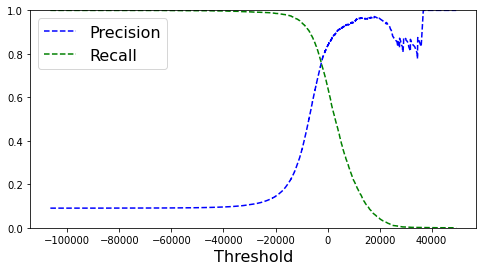

In [32]:
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisons,recalls,thresholds)
plt.show()

**Why the precision curve is bumpier than the recall curve ?**

The reason is that precision may sometimes go down when you raise the threshold (although in general it will go up).

Another way to select a good precision/recall trade-off is to plot precision directly against recall,

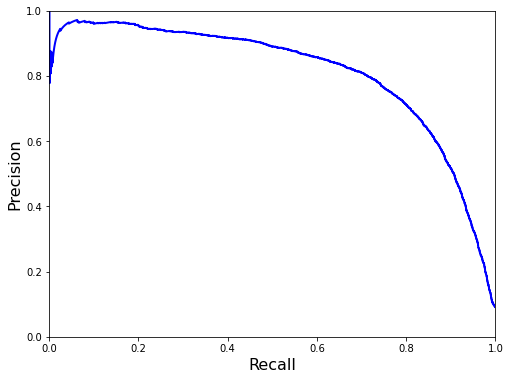

In [33]:
def plot_precision_vs_recall(precisons, recalls):
    plt.plot(recalls, precisons, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisons, recalls)
plt.show()

We can see that precision really starts to fall sharply around 80% recall. We will probably want to select a precision/recall trade-off just before that drop—for example, at around 60% recall. But of course, the choice depends on the project.


Assueme our aim is for 90% precision. We look up the first plot and find that we need to use a threshold of about 8,000. 
To be more precise we can search for the lowest threshold that gives  at least 90% precision
( np.argmax will give  the first index of the maximum value, which in this case means the first value)

In [34]:
thresholds_90_precision = thresholds[np.argmax(precisons>=0.9)]
thresholds_90_precision

3370.0194991439557

In [35]:
y_train_pred_90 = (y_scores > thresholds_90_precision)
precision_score(y_train5, y_train_pred_90)

0.9

In [36]:
recall_score(y_train5, y_train_pred_90)


0.47980077476480354

**A high-precision classifier is not very useful if its recall is too low!**


### The ROC Curve

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate (FPR)
i.e<br>
**ROC Curve = TPR VS FPR**

<font color="green"> FPR is the ratio of negative instances that are incorrectly classified as positive <br>
i.e 1 – the true negative rate (TNR) </font>

<font color="blue"> Specificity or TNR is ratio of negative instances that are correctly classified as negative </font>

**ROC curve plots sensitivity (recall) versus 1 – specificity**

In [37]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds = roc_curve(y_train5, y_scores)

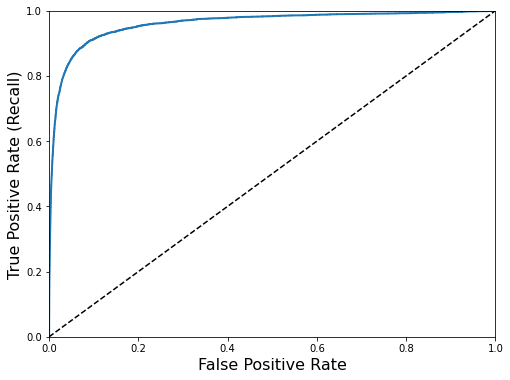

In [38]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

Once again there is a trade-off: <font color ='red'>**the higher the recall (TPR), the more false positives (FPR) the classifier produces**.</font> The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

One way to compare classifiers is to measure the area under the curve (AUC).<br> A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5


In [39]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train5, y_scores)

0.9604938554008616

**VVIMP**<br>
Since the ROC curve is so similar to the precision/recall (PR) curve, so how to decide which one to use ??.<br><font color='green'>
 As a rule of thumb, one should prefer the PR curve whenever the positive class is rare or when one care more about the false positives than the false negatives. Otherwise, use the ROC curve. </font> <br>
 For example, looking at the previous ROC curve (and the ROC AUC score), we may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non- 5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top-left corner).


 ### Training RandomForestClassifier and compare ROC/ROC AUC to SGDClassifier
<br>
 
RandomForestClassifier doesn't have decision_function instead it has predict_proba which returns an array
containing a row per instance and a column per class,each containing the probability that the given instance belongs to the given class


In [40]:

from sklearn.ensemble import RandomForestClassifier
forest_clf  =RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train5,cv=3,method='predict_proba')

In [41]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

roc_curve() function expects labels and scores ,but instead of scores we can give it class probabilities.
Let’s use the positive class’s probability as the score

In [42]:
y_scores_forest =y_probas_forest[:,1] # score = prob. of +ve class ( 2nd col)
fpr_forest,tpr_forest,thresholds_forest = roc_curve(y_train5,y_scores_forest)

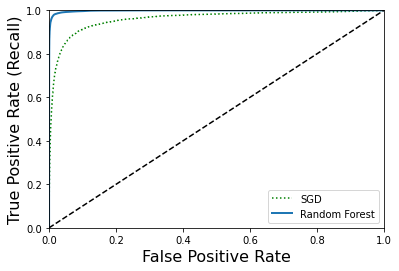

In [43]:
## plotting ROC curve 

plt.plot(fpr,tpr,'g:',label='SGD')
plot_roc_curve(fpr_forest,tpr_forest,"Random Forest")
plt.legend(loc="lower right")
plt.show()

**Comparing ROC curves**: the Random Forest classifier is superior to the SGD classifier because its ROC curve is much closer to the top-left corner, and it has a greater AUC

In [44]:
#getting roc_auc_score
roc_auc_score(y_train5,y_scores_forest)

0.9983436731328145

In [45]:
precisons_forest,recalls_forest,thresholds_for = precision_recall_curve(y_train5,y_scores_forest)
print(precisons_forest[:10],"\n",recalls_forest[:10])

[0.21697018 0.2782198  0.3359375  0.39168474 0.4434341  0.49221099
 0.53883011 0.58103448 0.62384152 0.65814579] 
 [1.         0.99981553 0.9994466  0.99926213 0.99852426 0.99667958
 0.99575724 0.99465043 0.99335916 0.99262129]


In [46]:
thresholds_90_precision_for = thresholds_for[np.argmax(precisons_forest>=0.9)]
thresholds_90_precision_for

0.24

In [47]:
y_train_pred_90_forest = (y_scores_forest > thresholds_90_precision_for)
precision_score(y_train5, y_train_pred_90_forest)

0.9098615916955017

In [48]:
recall_score(y_train5, y_train_pred_90_forest)

0.9701162147205312

As we see above, Getting precision and recall scores above using RandomForestClassifier is more than SGDClassifier.

### Multiclass Classification

There are various strategies that can be used to perform multiclass classification with multiple binary classifiers.<br>
- train 10 binary classifiers, one for each digit, Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the **one-versus-the-rest (OvR) strategy (also called one-versus-all)**
- train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s another for 1s and 2s and so on.This is called the **one-versus-one (OvO) strategy**. If there are N classes, you need to train N × (N – 1) / 2 classifiers.

The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.

Some algorithms (such as Support Vector Machine classifiers) scale poorly with the size of the training set. For these algorithms OvO is preferred because it is faster to train many classifiers on small training sets than to train few classifiers on large training sets. 

For most binary classification algorithms, however, OvR is preferred.

In [ ]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) ## note we are not using y_train5 here 
svm_clf.predict([some_digit])

array([5], dtype=uint8)

This  trains the SVC on the training set using original target classes from 0 to 9 (y_train) instead of the 5-vs-the-rest target classes ( y_train5). <br>
Then it makes a prediction (a correct one in this case). **Under the hood, Scikit-Learn actually used the OvO strategy**: it trained 45 binary classifiers, got their decision scores for the image, and selected the class that won the most duels.<br>
Now, Calling decison_score function returns 10 scores per instance i.e 1 score per class

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [ ]:
np.argmax(some_digit_scores)

5

AS we can see the  highest score is indeed the one corresponding to class 5

In [ ]:
print(svm_clf.classes_)
print(svm_clf.classes_[5])

[0 1 2 3 4 5 6 7 8 9]
5


When a classifier is trained, it stores the list of target classes in its attribute, ordered by value. In this case, the index of each class in the classes_ array conveniently matches the class itself (e.g., the class at index 5 happens to be class 5), but in general one won’t be so lucky.

In [ ]:
## force Scikit-Learn to use one-versus-one or one-versus-the- rest

from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train,y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
len(ovr_clf.estimators_)

10

In [ ]:
## Training SGDClassifier/RandomForestClassifier

sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

This time Scikit-Learn did not have to run OvR or OvO because SGD classifiers can directly classify instances into multiple classes. 

The decision_function() returns one value per class.

In [ ]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

We see that the classifier is fairly confident about its prediction: almost all scores are largely negative, while class 5  has a score of 2412.5

Now we can use cross_val_score to evalutate the SGDclassifier accuracy

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

It gets over 84% on all test folds. If we used a random classifier, we would get 10% accuracy, so this is not such a bad score, but we can still do much better. <br>
Simply scaling the inputs  increases accuracy above 89%

In [49]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

### Error Analysis

Assuming that we found a promising model and  want to find ways to improve it. One way to do this is to analyze the types of errors it makes. <br>

First, look at the confusion matrix. We need to make predictions using the cross_val_predict() function then call confusion_matrix().


In [50]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

**Note**: rows represent actual classes, while columns represent predicted classes.

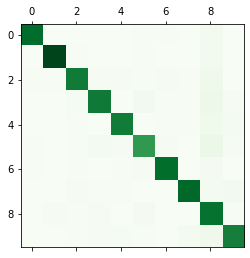

In [52]:
plt.matshow(conf_mx, cmap=plt.cm.Greens)
plt.show()

confusion matrix looks pretty good, since most images are on the main diagonal, which means that they were classified correctly <br>

The 5s look slightly darker than the other digits, which could mean that there are fewer images of 5s in the dataset or that the classifier does not perform as well on 5s as on other digits.

Let's Verify that both are the case and plot the error.
  1. divide each value in the confusion matrix by the number of images in the corresponding class so that we can compare error rates instead of absolute numbers of errors
  2.  Fill the diagonal with zeros to keep only the errors, and plot the result

In [53]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx= conf_mx/row_sums

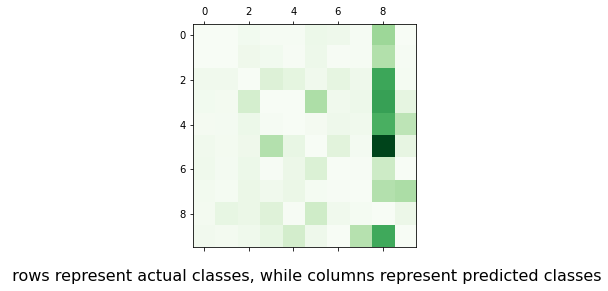

In [58]:
## Fill the diagonal with zeros to keep only the errors, and plot the result:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap=plt.cm.Greens)
plt.xlabel("\n rows represent actual classes, while columns represent predicted classes",fontsize=16)
plt.show()

rows represent actual classes, while columns represent predicted classes


The column for class 8 is quite bright, which tells that many images get misclassified as 8s. <br>
However, the row for class 8 is not that bad, telling that actual 8s in general get properly classified as 8s. <br>
confusion matrix is not necessarily symmetrical.

It seems efforts should be spent on reducing the false 8s. for e.g. gather more training data for digits that look like 8s (but are not) so that the classifier can learn to distinguish them from real 8s

### Multilabel Classification

Consider a face-recognition classifier: what should it do if it recognizes several people in the same picture? It should attach one tag per person it recognizes. <br>
Let the classifier has been trained to recognize three faces, Alice, Bob, and Charlie. Then when the classifier is shown a picture of Alice and Charlie, it should output [1, 0, 1].<br>
**Such a classification system that outputs multiple binary tags is called a multilabel classification system**

In [59]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train>=7)
y_train_odd = (y_train%2 ==1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

y_multilabel creates an array containing two target labels for each digit image: the first indicates whether or not the digit is large 
and second indicates whether or not it is odd.

In [60]:
knn_clf.predict([some_digit])

array([[False,  True]])

And it gets it right! The digit 5 is indeed not large ( False) and odd (odd ).

To evaluate a multilabel classifier, and selecting the right metric really depends on the project. <br>
one approach is to measure F1 Score for each individual label then compute the average score


In [68]:
y_train_knn_pred = cross_val_predict(knn_clf,X_train,y_multilabel,cv=3,n_jobs=-1)
f1_score(y_multilabel,y_train_knn_pred,average='macro')

KeyboardInterrupt: ignored

above assumes that all labels are equally important  <br>
In particular, if you have many more pictures of Alice than of Bob or Charlie, you may want to give more weight to the classifier’s score on pictures of Alice. <br>
One simple option is to give each label a weight equal to its support

In [ ]:
## giving weighted average to above 
f1_score(y_multilabel,y_train_knn_pred,average='weighted')

### Multioutput Classification (multioutput–multiclass classification)
It is a generalization of multilabel classification where each label can be multiclass . for e.g. <br>
Consider a system  that removes noise from images.<br>
I/P : noisy digit image <br>
O/P : clean digit image ,represented as an array of pixel intensities <br>

**Note**:   the classifier’s output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255). It is thus an example of a **multioutput classification system.**

Let’s start by creating the training and test sets by taking the MNIST images and adding noise to their pixel intensities with NumPy’s randint()

In [63]:
noise = np.random.randint(0,100, (len(X_train),784))
X_train_mod= X_train + noise
noise = np.random.randint(0,100, (len(X_test),784))
X_test_mod= X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [65]:
 def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,interpolation="nearest")
    plt.axis("off")

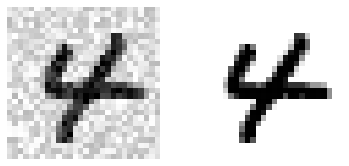

In [66]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

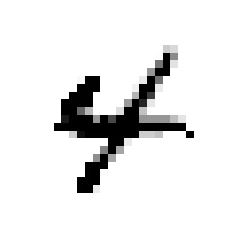

In [67]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)